# Setting the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Setup

Installing libraries.

In [ ]:
!pip install pytorch_lightning
!pip install transformers

     |████████████████████████████████| 819kB 5.2MB/s 
     |████████████████████████████████| 122kB 48.8MB/s 
     |████████████████████████████████| 235kB 39.5MB/s 
     |████████████████████████████████| 829kB 33.2MB/s 
     |████████████████████████████████| 645kB 28.1MB/s 
     |████████████████████████████████| 10.6MB 11.6MB/s 
     |████████████████████████████████| 1.3MB 34.8MB/s 
     |████████████████████████████████| 296kB 34.2MB/s 
     |████████████████████████████████| 143kB 41.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=8f6e1767ff65ff184a572a520f75f46928429acc53cdd69013d553bc01542291
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

Setting the root folder.

In [ ]:
ROOT = 'drive/MyDrive/Colab_Notebooks/NLP_HW2/'

Download the fastext embeddings

In [ ]:
N_VECTORS=100_001
!wget -O - \
    https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz 2> /dev/null |\
    gunzip | head -n $N_VECTORS > $ROOT/data/fasttext_embeddings.txt

Now we are going to import the libraries.

In [ ]:
# importing libraries
import string
import re
import os
from typing import *
import math
import random
import pickle
import collections

import json
import xml.etree.ElementTree as ET

from tqdm import tqdm
from pprint import pprint

#Numpy
import numpy as np

#Collections
from collections import defaultdict
from collections import Counter

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Metrics
from sklearn.metrics import precision_score as sk_precision
from sklearn.metrics import f1_score

#Torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#Pytorch lightning
import pytorch_lightning as pl


#Transformers
from transformers import AutoTokenizer, BertModel, AdamW

#NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#PLT
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We fix the seed in order to obtain reproducible executions.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We set the device on which load the data and the model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
device

'cuda'

We set the path of the dataset files.

In [ ]:
path_laptops_train = ROOT + 'data/laptops_train.json'
path_laptops_dev = ROOT + 'data/laptops_dev.json'

path_restaurants_train = ROOT + 'data/restaurants_train.json'
path_restaurants_dev = ROOT + 'data/restaurants_dev.json'

#Vocab

##Vocab class

We define the Vocab class. Objects of this class contain a list mapping integer to string, and a dictionary mapping string to integer.

In [ ]:
class Vocab():

    def __init__(self,
                 counter: Counter,
                 specials: Optional[List] = None,
                 min_freq = 1):
        
        # integer -> string
        self.itos = list()
        
        # string -> integer
        # 1 corresponds to the unknown token string
        self.stoi = defaultdict(lambda: 1)

        i = 0

        # the specials token (pad, unk) are the ones with the smallest integer
        if specials is not None:
            for special in specials:
                self.stoi[special] = i
                i += 1

        # building the stoi dictionary from the counter of the occurences of the strings
        for occ in counter:
            freq = counter[occ]
            if freq >= min_freq:
                self.stoi[occ] = i
                i += 1

        # building the itos list from the stoi dictionary
        for w in self.stoi:
            self.itos.append(w)


##Building vocabs

In [ ]:
# function that build the vocabulary of words in the dataset
def build_vocab(dataset, min_freq=1):
    counter = Counter()
    for i in tqdm(range(len(dataset))):
        w_BIO, _ = dataset.get_raw_element(i)
        for w, _ in w_BIO:
            if w is not None:
                counter[w]+=1
    return Vocab(counter, min_freq=min_freq, specials=['<pad>', '<unk>'])

# function that build the vocabulary of BIOs tags
def build_labels_BIO_vocab(dataset):
    counter = Counter()
    for i in tqdm(range(len(dataset))):
        w_BIO, _ = dataset.get_raw_element(i)
        for w, BIO in w_BIO:
            if w is not None:
                counter[BIO]+=1
    return Vocab(counter, specials=['<pad>'])

# function that build the vocabulary of sentiments
def build_labels_sentiments_vocab():
    counter = Counter()
    counter['positive'] = 1
    counter['negative'] = 1
    counter['neutral'] = 1
    counter['conflict'] = 1
    return Vocab(counter)

#Fasttext embeddings

Here we are going to load the fasttext word embeddings.

In [ ]:
# function that return a list of the fasttext vectors 
# in the same order of the itos list of the vocabulary of words
# (actually, the shape of the returned value is a matrix)
def get_fasttext_embedding(vocabulary: Vocab):   

    pad_embedding = torch.zeros(300) # pad embedding corresponds to a zeros vector
    unk_embedding = torch.randn(300) # unk embedding corresponds to a random vector

    word2fasttext_embedding = defaultdict(lambda: unk_embedding)
    word2fasttext_embedding['<pad>'] = pad_embedding
    word2fasttext_embedding['<unk>'] = unk_embedding

    #print('Loading Fasttext embedding')

    with open(ROOT + 'data/fasttext_embeddings.txt') as f:
        
        next(f)  # skip header
        
        for i, line in enumerate(tqdm(f)):
        
            token, *vector = line.strip().split(' ')

            vector = torch.tensor([float(c) for c in vector])
            word2fasttext_embedding[token] = vector

    vectors_fasttext = [word2fasttext_embedding[w] for w in vocabulary.itos]

    vectors_fasttext = torch.stack(vectors_fasttext)

    return vectors_fasttext

#Pre-Processing

In this section we are performing the pre-processing step for the sentences. 

In [ ]:
# removing punctuation and multiple spaces
def remove_punctuation(sentence: str):
    
    sentence = sentence.replace(chr(8221), ' ') # ”
    sentence = sentence.replace(chr(8220), ' ') # “
    sentence = sentence.replace(chr(8212), ' ') # —
    sentence = sentence.replace(chr(8211), ' ') # –
    sentence = sentence.replace(chr(8208), ' ') # ‐
    sentence = sentence.replace('\u00a0', '')
    
    sentence = sentence.replace(chr(8216), ' ') # ‘
    sentence = sentence.replace(chr(8217), ' ') # ’
    sentence = sentence.replace(chr(8221), ' ') # ”
    sentence = sentence.replace(chr(39), ' ') # '
    sentence = sentence.replace('/', ' ') # '
    sentence = sentence.replace('.', ' ') # '


    for punc in string.punctuation:
        if punc != '[' and punc != ']' and punc != '-':
            sentence = sentence.replace(punc, '')

    sentence = re.sub(' +', ' ', sentence)

    sentence = sentence.strip()

    return sentence

#Task A

##Dataset A

Here we are going to define the dataset for the task A.

In [ ]:
class ADataset(torch.utils.data.Dataset):

    def __init__(self, 
                 file_path_restaurants: str,
                 file_path_laptops: str,
                 device: str = 'cuda'):

        # device
        self.device = device

        # file paths
        self.file_path_restaurants = file_path_restaurants
        self.file_path_laptops = file_path_laptops
        
        # data as read from files
        raw_data = self._init_data()

        # processed data (text and BIOs tags)
        self.data = self._add_BIO(raw_data)

        # encoded data 
        # (words in the text and the BIOs tags are represented by integers)
        self.encoded_data = None

    # function that load the data from the files
    def _init_data(self):

        with open(self.file_path_restaurants) as f:
            data_restaurants = json.load(f)

        with open(self.file_path_laptops) as f:
            data_laptops = json.load(f)
        
        data = data_restaurants + data_laptops

        return data

    # function that process the raw data
    def _add_BIO(self, raw_data):

        data_with_BIO = []

        n_targets, n_B = 0, 0

        # for each instance of the dataset
        for instance in tqdm(raw_data):
            
            # retrieving targets and text
            targets = instance['targets']
            text = instance['text']

            text = text.replace('")S', '" S')

            n_targets += len(targets)

            # dict: (start, end) -> aspect_term
            start_end2aspect = {}

            # dict: (start, end) -> sentiment expressed toward the aspect_term
            start_end2sentiment_label = {}

            # for each target
            for target in targets:
                
                # retrieving the start and the end of the aspect term in the text
                # the aspect_term and the respectively sentiment
                start, end, aspect, sentiment_label = target[0][0], target[0][1], target[1], target[2]
                
                # store the info in the dictionaries
                start_end2aspect[start, end] = aspect
                start_end2sentiment_label[start, end] = sentiment_label

            # sort the dictionaries w.r.t. the keys from the end of the text towards the beginning
            start_end2aspect = collections.OrderedDict(sorted(start_end2aspect.items(), reverse=True))
            start_end2sentiment_label = collections.OrderedDict(sorted(start_end2sentiment_label.items(), reverse=True))

            # lowercasing the text
            text = text.lower()

            # adding highlighter to the aspect terms in the text 
            # each aspect term is surrounded by [Sx] and [xE]
            # where x an integer unique for each aspect term in the text
            for i, (start, end) in enumerate(start_end2aspect):
                text = text[:start] + '[S' + str(i) + ']' + text[start:end] + '[' + str(i) + 'E]' + text[end:]
                
            
            text = text.replace('free[S', 'free [S')
            text = text.replace('-[S', ' [S')

            # removing punctuation from the text
            text = remove_punctuation(text)

            #print('text:', text)
            
            # generating the BIOs tags 
            # each word in the text will correspond to one BIO tag
            sentence, BIOs = '', []
            in_aspect_term = False

            # for each word in the text
            for w in text.split():
                
                # if the word is an aspect term, it is associated to a B tag
                if w.startswith('[S') and w.endswith('E]'):
                    w = w[4:]
                    w = w[:-4]
                    sentence += w
                    BIOs.append('B')
                    n_B += 1
                
                # if the word is the first word of the aspect term, it is associated to a B tag
                elif w.startswith('[S'):
                    in_aspect_term = True
                    w = w[4:]
                    sentence += w
                    BIOs.append('B')
                    n_B += 1
                
                # if the word is the last word of the aspect term, it is associated to a I tag
                elif w.endswith('E]'):
                    in_aspect_term = False
                    w = w[:-4]
                    sentence += w
                    BIOs.append('I')

                # if the word is not the first nor the last word of the aspect,
                # but the in_aspect_term is true it is associated to a I tag
                elif not w.startswith('[S') and not w.endswith('E]') and in_aspect_term:
                    sentence += w
                    BIOs.append('I')

                # if the word is not the first nor the last word of the aspect and
                # the in_aspect_term is false it is associated to a O tag
                elif not w.startswith('[S') and not w.endswith('E]') and not in_aspect_term:
                    sentence += w
                    BIOs.append('O')

                sentence += ' '

            # list of the sentiments 
            sentiment_labels = list(start_end2sentiment_label.values())
            sentiment_labels.reverse() 

            # adding the processed instance to the data
            data_with_BIO.append(
                (list(zip(sentence.split(), BIOs)), sentiment_labels)
            )
            
        #print('n_targets:', n_targets)
        #print('n_B:', n_B)

        # returning the processed data
        return data_with_BIO

    # function that encodes the texts
    def index_dataset(self, vocabulary, labels_BIO_vocabulary):
        
        #print('Encoding dataset')

        self.encoded_data = list()

        for i in tqdm(range(len(self.data))):
            
            elem, sentiment_labels = self.data[i]

            # encoding words
            encoded_words = torch.LongTensor(self.encode_text(elem, vocabulary)).to(self.device)
            
            # encoding BIOs tags
            encoded_labels_BIO = torch.LongTensor(
                [labels_BIO_vocabulary.stoi[BIO] for _, BIO in elem]).to(self.device)

            assert len(encoded_words) == len(encoded_labels_BIO)

            self.encoded_data.append(
                {
                    "id": i,
                    "inputs": encoded_words,
                    "labels_BIO": encoded_labels_BIO,
                    "labels_sentiments": sentiment_labels
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("""Invoke index_dataset on this object before trying to retrieve elements""")
        return self.encoded_data[idx]
    
    def get_raw_element(self, idx):
        return self.data[idx]

    # function that index the sentence
    # (each word in the sentence is represented by the corresponding integer in the vocabulary)
    @staticmethod
    def encode_text(sentence_BIO: list, vocabulary: Vocab):

        indices = list()

        for w, _ in sentence_BIO:
            if w in vocabulary.stoi:
                indices.append(vocabulary.stoi[w])
            else:
                indices.append(vocabulary.stoi['<unk>'])

        return indices

##Model A

Here we are going to define the model for the task A.

In [ ]:
class AModel(nn.Module):
    
    def __init__(self, hparams, embeddings = None):
    
        super(AModel, self).__init__()

        # embedding layer
        if embeddings is not None:
            # pre-trained embedding
            self.word_embedding = nn.Embedding.from_pretrained(embeddings)
        else:
            self.word_embedding = nn.Embedding(hparams['vocab_size'], hparams['embedding_dim'])
        
        # LSTM layer
        self.lstm = nn.LSTM(
            hparams['embedding_dim'], 
            hparams['hidden_dim'], 
            bidirectional=hparams['bidirectional'],
            num_layers=hparams['num_layers'], 
            dropout = hparams['p_dropout'] if hparams['num_layers'] > 1 else 0
        )
        
        # lstm output dim
        lstm_output_dim = hparams['hidden_dim'] if hparams['bidirectional'] is False else hparams['hidden_dim'] * 2

        # Dropout
        self.dropout = nn.Dropout(hparams['p_dropout'])

        # Classifier layer
        self.classifier = nn.Linear(lstm_output_dim, hparams['num_classes'])

    
    def forward(self, x, lengths):
        
        # computing the embeddings
        embeddings = self.word_embedding(x)

        # computing dropout
        embeddings = self.dropout(embeddings)

        lengths = lengths.to('cpu')

        # computing the packed sequence
        out = torch.nn.utils.rnn.pack_padded_sequence(embeddings, 
                                                      lengths=lengths, 
                                                      batch_first=True, 
                                                      enforce_sorted=False)
        
        # computing the output of the LSTM
        out, _ = self.lstm(out)
        
        # unpacking the packed sequence
        out, lengths = torch.nn.utils.rnn.pad_packed_sequence(out, 
                                                              batch_first=True, 
                                                              padding_value=0)
        
        # computing dropout
        out = self.dropout(out)

        # computing the output of the classifier
        output = self.classifier(out)
        
        # returning the output of the classifier
        return output

##PL

###Datamodule A PL

Here we are going to define the PL datamodule for the task A.

In [ ]:
class ADataModule(pl.LightningDataModule):
    
    def __init__(self, 
                 path_laptops_train,
                 path_laptops_dev,
                 path_restaurants_train,
                 path_restaurants_dev,
                 batch_size,
                 device):
        super().__init__()

        # device
        self.device = device

        # batch size
        self.batch_size = batch_size

        # file paths

        self.path_laptops_train = path_laptops_train
        self.path_laptops_dev = path_laptops_dev

        self.path_restaurants_train = path_restaurants_train
        self.path_restaurants_dev = path_restaurants_dev

    def setup(self, stage=None):
        
        # training dataset
        self.trainingset = ADataset(self.path_restaurants_train, 
                                    self.path_laptops_train,
                                    device=self.device)
        
        # development dataset
        self.devset = ADataset(self.path_restaurants_dev,
                               self.path_laptops_dev,
                               device=self.device)

        # vocabulary of words w.r.t. the training dataset
        self.vocabulary = build_vocab(self.trainingset, min_freq=1)

        # vocabulary of BIOs tags
        self.labels_BIO_vocabulary = build_labels_BIO_vocab(self.trainingset)

        # indexing training dataset w.r.t. the vocabularies
        self.trainingset.index_dataset(self.vocabulary, 
                                       self.labels_BIO_vocabulary)
        
        # indexing development dataset w.r.t. the vocabularies
        self.devset.index_dataset(self.vocabulary, 
                                  self.labels_BIO_vocabulary)
    
    # training dataloader
    def train_dataloader(self):
        return DataLoader(self.trainingset, batch_size=self.batch_size, collate_fn=self._collate_fn)
    
    # validation dataloader
    def val_dataloader(self):
        return DataLoader(self.devset, batch_size=self.batch_size, collate_fn=self._collate_fn)

    # collate function
    def _collate_fn(self, samples):
        
        # ids of the instances
        ids = [sample['id'] for sample in samples]

        # encoded words of the texts
        inputs = [sample['inputs'] for sample in samples]

        # encoded BIOs tags
        labels_BIO = [sample['labels_BIO'] for sample in samples]

        # lengths of the texts
        lengths = [len(input) for input in inputs]
        lengths = torch.tensor(lengths, device='cpu')
        
        # padding the encoded texts and the BIOs tags
        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
        labels_BIO = torch.nn.utils.rnn.pad_sequence(labels_BIO, batch_first=True, padding_value=0)

        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'inputs': inputs, 
            'labels_BIO':labels_BIO, 
            'lengths': lengths
        }

###Model A PL

Here we are going to define the PL model for the task A.

In [ ]:
class AModelPL(pl.LightningModule):

    def __init__(self, hparams, embeddings = None, *args, **kwargs):
        super(AModelPL, self).__init__(*args, **kwargs)

        # saving hyper-parameters
        self.save_hyperparameters(hparams)
        
        # setting the loss function
        self.loss_function = nn.CrossEntropyLoss(
            ignore_index=0)

        # model A
        self.modelA = AModel(self.hparams, embeddings)

        self.n_epoch = 0
        
    # forward step
    def forward(self, x, lengths):

        # computing the output of the model A
        logits = self.modelA(x, lengths)

        # computing the predicted BIO tag
        predictions = torch.argmax(logits, -1)

        # returning the logits and the predictions
        return logits, predictions

    # training step
    def training_step(self, batch, batch_nb):
    
        inputs = batch['inputs']
        lengths = batch['lengths']
        gold_labels_BIO = batch['labels_BIO']

        #print('inputs:', inputs)
        #print('lengths:', lengths)
        #print('gold labels BIO:', gold_labels_BIO)

        # computing the forward step for the model A
        logits, _ = self.forward(inputs, lengths)

        # computing the loss
        logits_for_loss = logits.view(-1, logits.shape[-1])
        gold_labels_BIO_for_loss = gold_labels_BIO.view(-1)
        loss_BIO = self.loss_function(logits_for_loss, gold_labels_BIO_for_loss)

        # logging the loss
        self.log('train_loss_BIO', loss_BIO, prog_bar=True)

        # returning the loss
        return loss_BIO

    # end of each training epoch
    def training_epoch_end(self, training_step_outputs):
        
        # saving the number of the ended epoch and the total loss on the training set 
        # in a dictionary

        total_loss = 0
        for loss in training_step_outputs:
            total_loss += loss['loss'].item()

        self.returns = dict()
        
        self.returns['n_epoch'] = self.n_epoch
        self.returns['total_loss'] = total_loss

        self.n_epoch += 1

    # validation step
    def validation_step(self, batch, batch_nb):
        
        if self.n_epoch == 0:
            return

        inputs = batch['inputs']
        lengths = batch['lengths']
        gold_labels_BIO = batch['labels_BIO']

        #print('inputs:', inputs)
        #print('lengths:', lengths)
        #print('gold labels BIO:', gold_labels_BIO)

        # computing the forward step for the model A
        logits, predictions = self.forward(inputs, lengths)

        # computing the loss
        logits_for_loss = logits.view(-1, logits.shape[-1])
        gold_labels_BIO_for_loss = gold_labels_BIO.view(-1)
        loss_BIO = self.loss_function(logits_for_loss, gold_labels_BIO_for_loss)

        # logging the loss
        self.log('dev_loss_BIO', loss_BIO, prog_bar=True)

        gold_labels_BIO = gold_labels_BIO.tolist()
        #print('gold_labels_BIO:', gold_labels_BIO)

        predictions = predictions.tolist()
        #print('gold_labels_BIO:', gold_labels_BIO)
        
        # deleting the pad from the gold sequence of BIOs tags
        gold_labels_BIO = [list(filter(lambda w: w != adatamodule.labels_BIO_vocabulary.stoi['<pad>'], label)) 
                            for label in gold_labels_BIO]
        #print('gold_labels_BIO without pad:', gold_labels_BIO)

        # deleting the pad from the predicted sequence of BIOs tags
        predictions = [predictions[i][:len(gold_label_BIO)] 
                        for i, gold_label_BIO in enumerate(gold_labels_BIO)]
        #print('predictions without pad:', predictions)

        # returning the gold sequence of BIOs tags and the predicted one
        return (gold_labels_BIO, predictions)

    # end of each validation epoch
    def validation_epoch_end(self, validation_step_outputs):
        
        if self.n_epoch == 0:
            return

        #print('validation_step_outputs:', validation_step_outputs)

        # merge all the validation step outputs
        gold_labels_BIO, predicted_labels_BIO = [], []
        for validation_step_output in validation_step_outputs:
            gold_labels_BIO.extend(validation_step_output[0])
            predicted_labels_BIO.extend(validation_step_output[1])
        
        #print('gold_labels_BIO:', gold_labels_BIO)
        #print('predicted_labels_BIO:', predicted_labels_BIO)

        gold_labels_BIO = [val for sublist in gold_labels_BIO for val in sublist]
        predicted_labels_BIO = [val for sublist in predicted_labels_BIO for val in sublist]

        #print('flattened gold_labels_BIO:', gold_labels_BIO)
        #print('flattened predicted_labels_BIO:', predicted_labels_BIO)

        # computing the micro, macro, per class precision, F1-score and the confusion matrix
        # saving all these information in the returns dictionary 

        # Micro-P and Macro-P
        micro_precision = sk_precision(gold_labels_BIO, predicted_labels_BIO, average="micro", zero_division=0)
        macro_precision = sk_precision(gold_labels_BIO, predicted_labels_BIO, average="macro", zero_division=0)
        self.log('valid_macro_precision_BIO', macro_precision, prog_bar=True)
        self.returns['valid_macro_precision_BIO'] = macro_precision
        print("Micro Precision: {}\nMacro Precision: {}".format(micro_precision, macro_precision))

        # Per class-P
        per_class_precision = sk_precision(
            gold_labels_BIO, predicted_labels_BIO,
            labels = list(range(len(adatamodule.labels_BIO_vocabulary.itos))),
            average=None,
        zero_division=0)
        self.returns['per_class_precision'] = dict()
        print("Per class Precision:")
        for idx_class, precision in sorted(enumerate(per_class_precision), key=lambda elem: -elem[1]):
            label = adatamodule.labels_BIO_vocabulary.itos[idx_class]
            print(label, precision)
            self.returns['per_class_precision'][label] = precision

        # Macro-F1
        macro_F1 = f1_score(gold_labels_BIO, predicted_labels_BIO, average="macro", zero_division=0)
        self.log('valid_macro_F1', macro_F1, prog_bar = True)
        self.returns['valid_macro_F1'] = macro_F1
        print('Macro F1:', macro_F1)

        # Confusion Matrix
        cm = confusion_matrix(gold_labels_BIO, predicted_labels_BIO, normalize='true')
        self.returns['cm'] = cm
        
        RETURNS.append(self.returns)

        print()
        print('-'*50)
        print()

    # optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams['lr'])

##Experiments

In this section there is the code to peform the experiments.

In [ ]:
FOLDER_A = 'experiments/Task A/'

FOLDER = ROOT + FOLDER_A + 'Test n.5/'

# setting the hyper-parameters dictionary
hparams = {
    'batch_size': 1,
    'embedding_dim': 100,
    'hidden_dim': 128,
    'bidirectional': True,
    'num_layers': 2,
    'p_dropout': .2,
    'lr': 1e-3,
    'fasttext_embeddings': False
}

In [ ]:
# instantiating the datamodule
adatamodule = ADataModule(
    path_laptops_train, 
    path_laptops_dev, 
    path_restaurants_train, 
    path_restaurants_dev, 
    batch_size=hparams['batch_size'],
    device=device)

adatamodule.setup()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 1086/1086 [00:00<00:00, 17944.78it/s]


In [ ]:
# setting other hyper-parameters

hparams['num_classes'] = len(adatamodule.labels_BIO_vocabulary.itos)

if hparams['fasttext_embeddings']:
    fasttext_embeddings = get_fasttext_embedding(adatamodule.vocabulary)
    vocab_size, embedding_dim = fasttext_embeddings.shape
    hparams['vocab_size'] = vocab_size
    hparams['embedding_dim'] = embedding_dim
else:
    vocab_size = len(adatamodule.vocabulary.itos)
    hparams['vocab_size'] = vocab_size

In [ ]:
# saving the hyper-parameters in a json file
with open(FOLDER + "hparams.json", "w+") as hparams_file:
    json.dump(hparams, hparams_file)

# callback to save the best checkpoints (w.r.t. the F1-score) 
check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_macro_F1',
    verbose=True,
    save_top_k=3,
    mode='max',
    dirpath= FOLDER, 
    filename='{epoch}-{valid_macro_F1:.4f}'
)

# list of dictionaries in which the PL model class will store the information
# about the epoch, the loss and the metrics
RETURNS = []

# PL trainer
trainer = pl.Trainer(gpus=1 if device is 'cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=50,
                     callbacks=[check_point_callback],
                     )

# instantiating the model
if hparams['fasttext_embeddings']:
    model = AModelPL(hparams, fasttext_embeddings)
else:
    model = AModelPL(hparams)

# training the model
trainer.fit(model, datamodule=adatamodule)

# saving the RETURNS list in a file
with open(FOLDER + 'results.pkl', 'wb') as f:
    pickle.dump(RETURNS, f)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_function | CrossEntropyLoss | 0     
1 | modelA        | AModel           | 1.3 M 
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.115     Total estimated model params size (MB)


Epoch 0, global step 4999: valid_macro_F1 reached 0.69085 (best 0.69085), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=0-valid_macro_F1=0.6909.ckpt" as top 3


Micro Precision: 0.9359888012216849
Macro Precision: 0.7762184380692078
Per class Precision:
O 0.9520716532202926
B 0.7680209698558322
I 0.6085626911314985
<pad> 0.0
Macro F1: 0.6908504533163736

--------------------------------------------------



Epoch 1, global step 9999: valid_macro_F1 reached 0.73330 (best 0.73330), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=1-valid_macro_F1=0.7333.ckpt" as top 3


Micro Precision: 0.9391066429116823
Macro Precision: 0.7488244398807954
Per class Precision:
O 0.9687610182638742
B 0.6986425339366515
I 0.5790697674418605
<pad> 0.0
Macro F1: 0.733297994164014

--------------------------------------------------



Epoch 2, global step 14999: valid_macro_F1 reached 0.76060 (best 0.76060), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=2-valid_macro_F1=0.7606.ckpt" as top 3


Micro Precision: 0.9459786205141257
Macro Precision: 0.7824499106742234
Per class Precision:
O 0.9702163529081202
B 0.74784276126558
I 0.6292906178489702
<pad> 0.0
Macro F1: 0.7605955873186246

--------------------------------------------------



Epoch 3, global step 19999: valid_macro_F1 reached 0.75444 (best 0.76060), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=3-valid_macro_F1=0.7544.ckpt" as top 3


Micro Precision: 0.9496054975820819
Macro Precision: 0.8267666983360167
Per class Precision:
O 0.9662663982786146
B 0.7740336967294351
I 0.74
<pad> 0.0
Macro F1: 0.7544443254687961

--------------------------------------------------



Epoch 4, global step 24999: valid_macro_F1 reached 0.78174 (best 0.78174), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=4-valid_macro_F1=0.7817.ckpt" as top 3


Micro Precision: 0.9513234919826928
Macro Precision: 0.813360398918431
Per class Precision:
O 0.9707528687377553
B 0.7885771543086172
I 0.6807511737089202
<pad> 0.0
Macro F1: 0.7817374580582509

--------------------------------------------------



Epoch 5, global step 29999: valid_macro_F1 reached 0.77710 (best 0.78174), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=5-valid_macro_F1=0.7771.ckpt" as top 3


Micro Precision: 0.9518961567828964
Macro Precision: 0.8293818831364499
Per class Precision:
O 0.968343421693453
B 0.7954779033915724
I 0.7243243243243244
<pad> 0.0
Macro F1: 0.777099855296061

--------------------------------------------------



Epoch 6, global step 34999: valid_macro_F1 reached 0.78833 (best 0.78833), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=6-valid_macro_F1=0.7883.ckpt" as top 3


Micro Precision: 0.9510689742937134
Macro Precision: 0.8087847037880449
Per class Precision:
O 0.9759462327555712
B 0.7322033898305085
I 0.7182044887780549
<pad> 0.0
Macro F1: 0.7883260303334847

--------------------------------------------------



Epoch 7, global step 39999: valid_macro_F1 reached 0.78702 (best 0.78833), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=7-valid_macro_F1=0.7870.ckpt" as top 3


Micro Precision: 0.9534868923390175
Macro Precision: 0.8319406478800789
Per class Precision:
O 0.9708778545987848
B 0.7901960784313725
I 0.7347480106100795
<pad> 0.0
Macro F1: 0.7870230837166013

--------------------------------------------------



Epoch 8, global step 44999: valid_macro_F1 reached 0.78954 (best 0.78954), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=8-valid_macro_F1=0.7895.ckpt" as top 3


Micro Precision: 0.9526597098498346
Macro Precision: 0.8151931812740175
Per class Precision:
O 0.9739026449071468
B 0.7702205882352942
I 0.7014563106796117
<pad> 0.0
Macro F1: 0.7895442258072597

--------------------------------------------------



Epoch 9, global step 49999: valid_macro_F1 was not in top 3


Micro Precision: 0.9513871214049376
Macro Precision: 0.8113518969413022
Per class Precision:
O 0.97254406291693
B 0.7665116279069767
I 0.695
<pad> 0.0
Macro F1: 0.7813199187821448

--------------------------------------------------



Epoch 10, global step 54999: valid_macro_F1 reached 0.79308 (best 0.79308), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=10-valid_macro_F1=0.7931.ckpt" as top 3


Micro Precision: 0.9538686688724867
Macro Precision: 0.827734237171594
Per class Precision:
O 0.9734016422205067
B 0.774582560296846
I 0.7352185089974294
<pad> 0.0
Macro F1: 0.7930771712975636

--------------------------------------------------



Epoch 11, global step 59999: valid_macro_F1 was not in top 3


Micro Precision: 0.9499872741155511
Macro Precision: 0.7986292131549805
Per class Precision:
O 0.9745020483119085
B 0.7486583184257602
I 0.6727272727272727
<pad> 0.0
Macro F1: 0.7841076629663438

--------------------------------------------------



Epoch 12, global step 64999: valid_macro_F1 was not in top 3


Micro Precision: 0.9533596334945279
Macro Precision: 0.82690067069981
Per class Precision:
O 0.9710033538289548
B 0.7972304648862513
I 0.712468193384224
<pad> 0.0
Macro F1: 0.7866331388760014

--------------------------------------------------



Epoch 13, global step 69999: valid_macro_F1 reached 0.78895 (best 0.79308), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=13-valid_macro_F1=0.7889.ckpt" as top 3


Micro Precision: 0.9521506744718758
Macro Precision: 0.8187943889838395
Per class Precision:
O 0.9730812482429013
B 0.7640036730945822
I 0.7192982456140351
<pad> 0.0
Macro F1: 0.7889491022023053

--------------------------------------------------



Epoch 14, global step 74999: valid_macro_F1 reached 0.79179 (best 0.79308), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=14-valid_macro_F1=0.7918.ckpt" as top 3


Micro Precision: 0.9507508271824892
Macro Precision: 0.7987025953242117
Per class Precision:
O 0.9770212765957447
B 0.7370689655172413
I 0.6820175438596491
<pad> 0.0
Macro F1: 0.7917941420076481

--------------------------------------------------



Epoch 15, global step 79999: valid_macro_F1 was not in top 3


Micro Precision: 0.9503054212267753
Macro Precision: 0.8025941276794128
Per class Precision:
O 0.9750512403703442
B 0.7402482269503546
I 0.6924829157175398
<pad> 0.0
Macro F1: 0.7882531662339054

--------------------------------------------------



Epoch 16, global step 84999: valid_macro_F1 was not in top 3


Micro Precision: 0.9513871214049376
Macro Precision: 0.8097498105952319
Per class Precision:
O 0.9752101137085952
B 0.7432550043516101
I 0.7107843137254902
<pad> 0.0
Macro F1: 0.7887415095655778

--------------------------------------------------



Epoch 17, global step 89999: valid_macro_F1 was not in top 3


Micro Precision: 0.9483965385594298
Macro Precision: 0.7819131667086309
Per class Precision:
O 0.9776591960156528
B 0.7246376811594203
I 0.6434426229508197
<pad> 0.0
Macro F1: 0.7837587901286631

--------------------------------------------------



Epoch 18, global step 94999: valid_macro_F1 was not in top 3


Micro Precision: 0.9518961567828964
Macro Precision: 0.8120696677041126
Per class Precision:
O 0.9739619985925405
B 0.7574123989218329
I 0.7048346055979644
<pad> 0.0
Macro F1: 0.7836443623966861

--------------------------------------------------



Epoch 19, global step 99999: valid_macro_F1 was not in top 3


Micro Precision: 0.9515780096716722
Macro Precision: 0.8072608246944487
Per class Precision:
O 0.9730831400660622
B 0.7767175572519084
I 0.6719817767653758
<pad> 0.0
Macro F1: 0.7850485375385259

--------------------------------------------------



Epoch 20, global step 104999: valid_macro_F1 was not in top 3


Micro Precision: 0.9529142275388139
Macro Precision: 0.8218167836986193
Per class Precision:
O 0.9718585929296465
B 0.7844080846968239
I 0.7091836734693877
<pad> 0.0
Macro F1: 0.784834228885842

--------------------------------------------------



Epoch 21, global step 109999: valid_macro_F1 was not in top 3


Micro Precision: 0.9515143802494274
Macro Precision: 0.815111420829222
Per class Precision:
O 0.9736860620558644
B 0.7477876106194691
I 0.7238605898123325
<pad> 0.0
Macro F1: 0.7815603927577354

--------------------------------------------------



Epoch 22, global step 114999: valid_macro_F1 reached 0.79261 (best 0.79308), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=22-valid_macro_F1=0.7926.ckpt" as top 3


Micro Precision: 0.9520870450496309
Macro Precision: 0.8146703534424465
Per class Precision:
O 0.9748236953455571
B 0.7511150758251561
I 0.7180722891566265
<pad> 0.0
Macro F1: 0.7926055681658936

--------------------------------------------------



Epoch 23, global step 119999: valid_macro_F1 reached 0.80082 (best 0.80082), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=23-valid_macro_F1=0.8008.ckpt" as top 3


Micro Precision: 0.9540595571392212
Macro Precision: 0.8244643686647591
Per class Precision:
O 0.9754000140974132
B 0.764336917562724
I 0.7336561743341404
<pad> 0.0
Macro F1: 0.8008175012002181

--------------------------------------------------



Epoch 24, global step 124999: valid_macro_F1 reached 0.79990 (best 0.80082), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=24-valid_macro_F1=0.7999.ckpt" as top 3


Micro Precision: 0.9532323746500382
Macro Precision: 0.8106421645684364
Per class Precision:
O 0.9770733088027173
B 0.7579505300353356
I 0.6969026548672567
<pad> 0.0
Macro F1: 0.7998962928037067

--------------------------------------------------



Epoch 25, global step 129999: valid_macro_F1 reached 0.80460 (best 0.80460), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task A/Test n.5/epoch=25-valid_macro_F1=0.8046.ckpt" as top 3


Micro Precision: 0.955395775006363
Macro Precision: 0.8226543255250475
Per class Precision:
O 0.9769968952864804
B 0.7720720720720721
I 0.7188940092165899
<pad> 0.0
Macro F1: 0.8045987442883544

--------------------------------------------------



Epoch 26, global step 134999: valid_macro_F1 was not in top 3


Micro Precision: 0.953741410027997
Macro Precision: 0.8156472189286427
Per class Precision:
O 0.9752747252747253
B 0.7751152073732719
I 0.696551724137931
<pad> 0.0
Macro F1: 0.7958379277166122

--------------------------------------------------



Epoch 27, global step 139999: valid_macro_F1 was not in top 3


Micro Precision: 0.9492237210486129
Macro Precision: 0.7919485655665396
Per class Precision:
O 0.9764338444065872
B 0.7320205479452054
I 0.6673913043478261
<pad> 0.0
Macro F1: 0.7869589955141425

--------------------------------------------------



Epoch 28, global step 144999: valid_macro_F1 was not in top 3


Micro Precision: 0.9510053448714686
Macro Precision: 0.8030751134478594
Per class Precision:
O 0.976207336071378
B 0.7433628318584071
I 0.6896551724137931
<pad> 0.0
Macro F1: 0.7950725237047843

--------------------------------------------------



Epoch 29, global step 149999: valid_macro_F1 was not in top 3


Micro Precision: 0.9510053448714686
Macro Precision: 0.7968313798327261
Per class Precision:
O 0.9771598808341608
B 0.7473591549295775
I 0.6659751037344398
<pad> 0.0
Macro F1: 0.7938680874656238

--------------------------------------------------



Epoch 30, global step 154999: valid_macro_F1 was not in top 3


Micro Precision: 0.9474420972257572
Macro Precision: 0.7864998586821158
Per class Precision:
O 0.9776130044203621
B 0.7043973941368078
I 0.6774891774891775
<pad> 0.0
Macro F1: 0.7866540343386634

--------------------------------------------------



Epoch 31, global step 159999: valid_macro_F1 was not in top 3


Micro Precision: 0.9478875031814711
Macro Precision: 0.7788763936426641
Per class Precision:
O 0.9775609061119818
B 0.7361477572559367
I 0.6229205175600739
<pad> 0.0
Macro F1: 0.787729628600971

--------------------------------------------------



Epoch 32, global step 164999: valid_macro_F1 was not in top 3


Micro Precision: 0.946678544158819
Macro Precision: 0.7805429975940354
Per class Precision:
O 0.9754418340549365
B 0.7157446808510638
I 0.6504424778761062
<pad> 0.0
Macro F1: 0.7745291463273323

--------------------------------------------------



Epoch 33, global step 169999: valid_macro_F1 was not in top 3


Micro Precision: 0.9493509798931026
Macro Precision: 0.7856759671580722
Per class Precision:
O 0.9790314528207689
B 0.7247706422018348
I 0.6532258064516129
<pad> 0.0
Macro F1: 0.7914493412676729

--------------------------------------------------



Epoch 34, global step 174999: valid_macro_F1 was not in top 3


Micro Precision: 0.9506871977602444
Macro Precision: 0.7927918753661424
Per class Precision:
O 0.97884314004844
B 0.7369308600337268
I 0.6626016260162602
<pad> 0.0
Macro F1: 0.7966567253520068

--------------------------------------------------



Epoch 35, global step 179999: valid_macro_F1 was not in top 3


Micro Precision: 0.9470603206922881
Macro Precision: 0.7815617609114781
Per class Precision:
O 0.9779584849133319
B 0.7015285599356396
I 0.6651982378854625
<pad> 0.0
Macro F1: 0.781289876438645

--------------------------------------------------



Epoch 36, global step 184999: valid_macro_F1 was not in top 3


Micro Precision: 0.9516416390939171
Macro Precision: 0.8059108588650398
Per class Precision:
O 0.975687327726341
B 0.752
I 0.6900452488687783
<pad> 0.0
Macro F1: 0.7921403433713715

--------------------------------------------------



Epoch 37, global step 189999: valid_macro_F1 was not in top 3


Micro Precision: 0.9493509798931026
Macro Precision: 0.790515963827689
Per class Precision:
O 0.9781416874332503
B 0.7210657785179018
I 0.6723404255319149
<pad> 0.0
Macro F1: 0.7905599642891595

--------------------------------------------------



Epoch 38, global step 194999: valid_macro_F1 was not in top 3


Micro Precision: 0.9478238737592263
Macro Precision: 0.7849843174031473
Per class Precision:
O 0.9776305478378571
B 0.7106557377049181
I 0.6666666666666666
<pad> 0.0
Macro F1: 0.7840925692572279

--------------------------------------------------



Epoch 39, global step 199999: valid_macro_F1 was not in top 3


Micro Precision: 0.9489055739373886
Macro Precision: 0.7930324469489204
Per class Precision:
O 0.9757584349305358
B 0.7276632302405498
I 0.6756756756756757
<pad> 0.0
Macro F1: 0.7836830127385473

--------------------------------------------------



Epoch 40, global step 204999: valid_macro_F1 was not in top 3


Micro Precision: 0.9475693560702468
Macro Precision: 0.7782333052945897
Per class Precision:
O 0.979062455338002
B 0.709546925566343
I 0.6460905349794238
<pad> 0.0
Macro F1: 0.7848987829685327

--------------------------------------------------



Epoch 41, global step 209999: valid_macro_F1 was not in top 3


Micro Precision: 0.947123950114533
Macro Precision: 0.7754063687781372
Per class Precision:
O 0.9783803068141277
B 0.7127303182579564
I 0.6351084812623274
<pad> 0.0
Macro F1: 0.7828721293975419

--------------------------------------------------



Epoch 42, global step 214999: valid_macro_F1 was not in top 3


Micro Precision: 0.9502417918045304
Macro Precision: 0.7966781574016545
Per class Precision:
O 0.9766633565044687
B 0.7361702127659574
I 0.6772009029345373
<pad> 0.0
Macro F1: 0.7881628224697591

--------------------------------------------------



Epoch 43, global step 219999: valid_macro_F1 was not in top 3


Micro Precision: 0.9472512089590227
Macro Precision: 0.7773689211136786
Per class Precision:
O 0.9798782670963122
B 0.7011128775834659
I 0.6511156186612576
<pad> 0.0
Macro F1: 0.7870766329378321

--------------------------------------------------



Epoch 44, global step 224999: valid_macro_F1 was not in top 3


Micro Precision: 0.9507508271824892
Macro Precision: 0.7985689844146994
Per class Precision:
O 0.9764872521246459
B 0.7408056042031523
I 0.6784140969162996
<pad> 0.0
Macro F1: 0.7895771802478336

--------------------------------------------------



Epoch 45, global step 229999: valid_macro_F1 was not in top 3


Micro Precision: 0.9482056502926953
Macro Precision: 0.7831065888311451
Per class Precision:
O 0.9785444436524342
B 0.7078288942695722
I 0.6629464285714286
<pad> 0.0
Macro F1: 0.7812902066849463

--------------------------------------------------



Epoch 46, global step 234999: valid_macro_F1 was not in top 3


Micro Precision: 0.9473784678035123
Macro Precision: 0.7767580443501537
Per class Precision:
O 0.9791324233545344
B 0.7085714285714285
I 0.642570281124498
<pad> 0.0
Macro F1: 0.7849856962430946

--------------------------------------------------



Epoch 47, global step 239999: valid_macro_F1 was not in top 3


Micro Precision: 0.9521506744718758
Macro Precision: 0.8002270887418684
Per class Precision:
O 0.9772678988740174
B 0.7553191489361702
I 0.6680942184154176
<pad> 0.0
Macro F1: 0.7931517891321757

--------------------------------------------------



Epoch 48, global step 244999: valid_macro_F1 was not in top 3


Micro Precision: 0.9499236446933061
Macro Precision: 0.7861100973847467
Per class Precision:
O 0.9782268393339975
B 0.7491071428571429
I 0.6309963099630996
<pad> 0.0
Macro F1: 0.7936091785977769

--------------------------------------------------



Epoch 49, global step 249999: valid_macro_F1 was not in top 3


Micro Precision: 0.9518325273606516
Macro Precision: 0.7988110608598137
Per class Precision:
O 0.9784648187633262
B 0.7465397923875432
I 0.6714285714285714
<pad> 0.0
Macro F1: 0.7994671028658008

--------------------------------------------------




###Plots

In this section there is the code to plot the results of the trained models.

In [ ]:
FOLDER = FOLDER = ROOT + FOLDER_A

models_results = []

# retrieving the models results from the file with the RETURNS list

for i in range(1,5):
    
    with open(FOLDER + 'Test n.' + str(i) + '/' + 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    models_results.append(results)

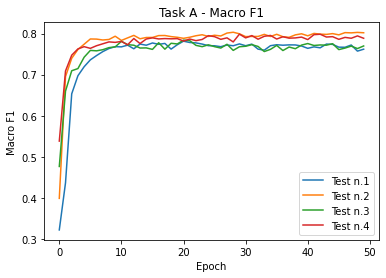

In [ ]:
# plot the F1-score on the validation set over the epochs for each trained model

for i, model_results in enumerate(models_results):
    macro_F1 = [result['valid_macro_F1'] for result in model_results]
    plt.plot(macro_F1, label='Test n.'+str(i+1))

plt.title('Task A - Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.show()

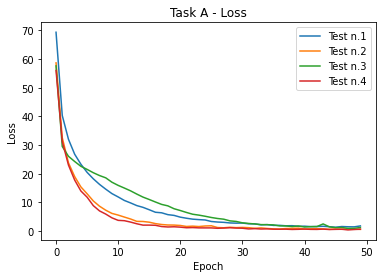

In [ ]:
# plot the loss on the training set over the epochs for each trained model

for i, model_results in enumerate(models_results):
    losses = [result['total_loss'] for result in model_results]
    plt.plot(losses, label='Test n.'+str(i+1))

plt.title('Task A - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

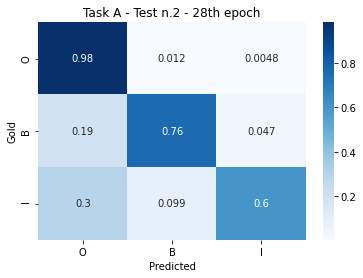

In [ ]:
# plot the confusion matrix of the best model

best = models_results[1][28]

cm = best['cm']

ax = plt.axes()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2g', ax=ax, 
            xticklabels=['O', 'B', 'I'], yticklabels=['O', 'B', 'I'])

ax.set_title('Task A - Test n.2 - 28th epoch')
plt.xlabel('Predicted')
plt.ylabel('Gold')
plt.show()

In [ ]:
# printing the saved information about the best model
pprint(best)

{'cm': array([[0.98291507, 0.01226428, 0.00482064],
       [0.19378428, 0.75959781, 0.04661792],
       [0.29844961, 0.09883721, 0.60271318]]),
 'n_epoch': 28,
 'per_class_precision': {'<pad>': 0.0,
                         'B': 0.7876777251184834,
                         'I': 0.7232558139534884,
                         'O': 0.974281498137868},
 'total_loss': 1.3393760376493447,
 'valid_macro_F1': 0.8031558323070703,
 'valid_macro_precision_BIO': 0.8284050124032799}


#Task B

##Dataset B

Here we are going to define the dataset for the task B.

In [ ]:
class BDataset(torch.utils.data.Dataset):

    def __init__(self, 
                 labels_sentiments_vocabulary,
                 file_path_restaurants,
                 file_path_laptops,              
                 device: str = 'cuda'):

        # device
        self.device = device

        # file paths
        self.file_path_restaurants = file_path_restaurants
        self.file_path_laptops = file_path_laptops
        
        # vocabulary of the sentiments
        self.labels_sentiments_vocabulary = labels_sentiments_vocabulary

        # instantiating the dataset A
        datasetA = ADataset(self.file_path_restaurants,
                            self.file_path_laptops, 
                            self.device)

        # retreving the data from the dataset A
        self.raw_data = datasetA.data
        #print('len(raw_data):', len(self.raw_data))

        # duplicating the instances for each aspect term in the text
        sentence_aspect_pairs_data = self._generate_sentence_aspect_pairs(self.raw_data)
        #print('len(sentence_aspect_pairs_data):', len(sentence_aspect_pairs_data))
        
        # duplicating the instances for each sentiment generating the auxiliary sentences
        self.data = self._generate_sentence_pairs_data(sentence_aspect_pairs_data)
        #print('len(data):', len(self.data))


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_raw_element(self, idx):
        return self.raw_data[idx]

    # function that duplicate the instances for each sentiment generating the auxiliary sentences
    def _generate_sentence_pairs_data(self, sentence_aspect_pairs_data):

        data = []

        # for each instance
        for id, sentence1, aspect, label_sentiment in sentence_aspect_pairs_data:
            
            # for each sentiment
            for i_label, label in enumerate(self.labels_sentiments_vocabulary.itos):
                
                # generating the auxiliary sentence of the shape
                # aspect:sentiment
                sentence2 = aspect + ':' + label

                # gold binary label if the sentiment in the auxiliary sentence is that one of the gold sentiment label
                gold = label == label_sentiment

                # generating a new id
                new_id = str(id) + '.' + str(i_label)

                # adding the new instance to the data
                data.append(
                    (new_id, sentence1, sentence2, gold)
                )

        # returning the data
        return data

    # function that duplicate the instances for each aspect term in the text
    def _generate_sentence_aspect_pairs(self, raw_data):
        
        data = []

        # dict: id -> { i1->([i1,i1+1,..e1],sentiment1), i2->([i2,i2+1,..e2], sentiment2), ... }
        id2start_aspect2list_index_aspect = {}

        n = 0
        n_labels_sentiment = Counter()

        # for each instance
        for id, (words_BIOs, labels_sentiment) in enumerate(raw_data):

            # counting the total number of aspect terms, 
            # the total number of sentiments,
            # the number of each sentiment label            
            n_aspect = 0
            n += len(labels_sentiment)
            for label in labels_sentiment:
                n_labels_sentiment[label] += 1
            
            id2start_aspect2list_index_aspect[id] = {}
            #print()
            #print('id:', id, '\t', words_BIOs, '\t', labels_sentiment)

            # building the original text
            sentence = ' '.join([w for w, _ in words_BIOs])

            # building the id2start_aspect2list_index_aspect dictionary 
            for i, (w, BIO) in enumerate(words_BIOs):
                #print('i:', i, '\t', w, '\t', BIO)
                if BIO == 'B':
                    id2start_aspect2list_index_aspect[id][i] = ([i], labels_sentiment[n_aspect])
                    n_aspect += 1
                    j = i + 1 
                    while j < len(words_BIOs) and words_BIOs[j][1][0] == 'I':
                        id2start_aspect2list_index_aspect[id][i][0].append(j)
                        j += 1
            
            # if there is at least one aspect term in the sentence
            # we append the new instance in the data
            if len(id2start_aspect2list_index_aspect[id].keys()) > 0:
                data.append(
                    (id, sentence, id2start_aspect2list_index_aspect[id])
                )
                
        print('total_labels_sentiment:', n)
        print('n_labels_sentiment:', n_labels_sentiment)

        # checking the detected aspect terms
        detected_aspect = 0
        for x in id2start_aspect2list_index_aspect:
            detected_aspect += len(id2start_aspect2list_index_aspect[x])

        #print('detected_aspect:', detected_aspect)

        #print('id2start_aspect2list_index_aspect:', id2start_aspect2list_index_aspect)

        return_data = []

        # for each new instance
        for id, sentence, start_aspect2indexes_aspect_label in data:
            
            sentence_splitted = sentence.split()
            j = 0
            
            # for each aspect term
            for start in start_aspect2indexes_aspect_label:
                indexes_aspect, label_sentiment = start_aspect2indexes_aspect_label[start]
                end = indexes_aspect[-1]

                sentence1 = ''

                # adding the " to highlight the aspect term
                for i, w in enumerate(sentence_splitted):
                    
                    if i == start and i == end:
                        sentence1 += '"'
                        sentence1 += w
                        sentence1 += '" '
                                     
                    elif i == start:
                        sentence1 += '"'
                        sentence1 += (w + ' ')

                    elif i == end:
                        sentence1 += w
                        sentence1 += '" '

                    else:
                        sentence1 += (w + ' ')
                
                # retrieving the aspect term
                aspect = ' '.join(sentence_splitted[start:end+1])

                sentence1 = sentence1.strip()
                aspect = aspect.strip()
                
                # generating a new id for the new instance
                id_n_aspect = str(id) + '.' + str(j)

                # adding the new instance
                return_data.append(
                    (id_n_aspect, sentence1, aspect, label_sentiment)
                )

                j += 1

        # returning the data
        return return_data

##Model B

Here we are going to define the model for the task B.

In [ ]:
class BModel(nn.Module):
    
    def __init__(self, p_dropout):
        
        super(BModel, self).__init__()
        
        # BERT layer
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased',
            output_hidden_states = True).to(device)

        # classifier layer
        self.classifier = torch.nn.Linear(768, 1)

        # self.lin1 = torch.nn.Linear(768, 384)
        # self.lin2 = torch.nn.Linear(384, 1)

        # Dropout
        self.dropout = torch.nn.Dropout(p=p_dropout)
    
    def forward(self, 
                tokens: torch.Tensor, 
                token_type_ids,
                attention_mask
                ):

        batch_size, seq_len = tokens.shape

        # computing the BERT forward step
        bert_embeddings = self.bert(
            input_ids=tokens,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # retrieving all the hidden embeddings for each token
        hidden_states = bert_embeddings[2]
        token_embeddings = torch.stack(hidden_states, dim=0)
        
        # retrieving the last hidden embeddings for each token
        last_hidden_embeddings = token_embeddings[-1]
        
        # retrieving the last hidden embeddings corresponding to the first [CLS] token
        last_hidden_CLS_embeddings = last_hidden_embeddings[:, 0, :]

        # computing dropout
        out = self.dropout(last_hidden_CLS_embeddings)

        # computing the output of the classifier
        out = self.classifier(out)

        # out = self.lin1(out)
        # out = self.dropout(out)
        # out = self.lin2(out)

        out = out.squeeze(1)

        # computing the sigmoid function to obtain a value in [0,1]
        out = torch.sigmoid(out)

        # returning the output of the model
        return out

##PL

###Datamodule B PL

Here we are going to define the PL datamodule for the task B.

In [ ]:
class BDataModule(pl.LightningDataModule):
    def __init__(self, 
                 path_laptops_train,
                 path_laptops_dev,
                 path_restaurants_train,
                 path_restaurants_dev,
                 batch_size,
                 device = 'cuda'):
        super().__init__()

        # device
        self.device = device

        # batch size
        self.batch_size = batch_size

        # file paths

        self.path_laptops_train = path_laptops_train
        self.path_laptops_dev = path_laptops_dev

        self.path_restaurants_train = path_restaurants_train
        self.path_restaurants_dev = path_restaurants_dev

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    def setup(self, stage=None):
        
        # building the vocabulary of the sentiments
        self.labels_sentiment_vocabulary = build_labels_sentiments_vocab()

        # training dataset
        self.trainingset = BDataset(
            self.labels_sentiment_vocabulary,
            file_path_restaurants=self.path_restaurants_train, 
            file_path_laptops=self.path_laptops_train,
            device=self.device)
        
        # validation dataset
        self.devset = BDataset(
            self.labels_sentiment_vocabulary,
            file_path_restaurants=self.path_restaurants_dev, 
            file_path_laptops=self.path_laptops_dev,
            device=self.device)
        
    # training dataloader
    def train_dataloader(self):
        return DataLoader(self.trainingset, batch_size=self.batch_size, collate_fn=self._collate_fn)
    
    # validation dataloader
    def val_dataloader(self):
        return DataLoader(self.devset, batch_size=self.batch_size, collate_fn=self._collate_fn)

    # collate function
    def _collate_fn(self, samples): 

        # shape of the single sample in sample: (new_id, sentence1, sentence2, gold)
        
        #print('samples:', samples)
        
        # ids of the instances
        ids = [sample[0] for sample in samples]

        # oringinal texts of the instances
        sentences1 = [sample[1] for sample in samples]

        # auxiliary sentences of the instances
        sentences2 = [sample[2] for sample in samples]

        # binary gold labels
        golds = [sample[3] for sample in samples]

        # tokenize the sentences
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)
        #print('tokenized_sentences:', tokenized_sentences)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=self.device)
        token_type_ids = torch.tensor(token_type_ids, device=self.device)
        attention_mask = torch.tensor(attention_mask, device=self.device)

        # tensor the labels
        golds = [np.float32(1) if gold is True else np.float32(0) for gold in golds]
        golds = torch.tensor(golds, device=self.device)
        
        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'tokens': tokens, 
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'golds': golds
        }

###Model B PL

In [ ]:
class BModelPL(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(BModelPL, self).__init__(*args, **kwargs)

        # saving hyper-parameters
        self.save_hyperparameters(hparams)
        
        # model B
        self.modelB = BModel(p_dropout=self.hparams['p_dropout'])

        # setting the loss function
        self.loss_function = torch.nn.BCELoss()

        self.n_epoch = 0
        
    # forward step
    def forward(self, tokens, token_type_ids, attention_mask):
        
        # computing the output of the model A
        logits = self.modelB(tokens, token_type_ids, attention_mask)

        # returning the logits
        return logits

    # training step
    def training_step(self, batch, batch_nb):
        
        ids = batch['ids']
        tokens = batch['tokens'] 
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        golds = batch['golds']

        #print('ids:', ids)
        #print('tokens:', tokens)
        #print('token_type_ids:', token_type_ids)
        #print('attention_mask:', attention_mask)
        #print('golds:', golds)
        
        # computing the forward step for the model B
        out = self.forward(tokens, token_type_ids, attention_mask)

        #computing and logging the loss
        loss_sentiment = self.loss_function(out, golds)
        self.log('train_loss_sentiment', loss_sentiment, prog_bar=True)

        # returning the loss
        return loss_sentiment

    # end of each training epoch
    def training_epoch_end(self, training_step_outputs):
        
        # saving the number of the ended epoch and the total loss on the training set 
        # in a dictionary

        total_loss = 0
        for loss in training_step_outputs:
            total_loss += loss['loss'].item()

        self.returns = dict()
        
        self.returns['n_epoch'] = self.n_epoch
        self.returns['total_loss'] = total_loss

        self.n_epoch += 1

    # validation step
    def validation_step(self, batch, batch_nb):
        
        if self.n_epoch == 0:
            return

        ids = batch['ids']
        tokens = batch['tokens'] 
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        golds = batch['golds']

        #print('ids:', ids)
        #print('tokens:', tokens)
        #print('token_type_ids:', token_type_ids)
        #print('attention_mask:', attention_mask)
        #print('golds:', golds)
        
        # computing the forward step for the model B
        out = self.forward(tokens, token_type_ids, attention_mask)

        # computing and logging the loss
        loss_sentiment = self.loss_function(out, golds)
        self.log('dev_loss_sentiment', loss_sentiment, prog_bar=True)
       
        # returning the ids, the gold labels and the predicted ones
        return (ids, out, golds)

    # end of each validation epoch
    def validation_epoch_end(self, validation_step_outputs):
        
        if self.n_epoch == 0:
            return
        
        # merge all the validation step outputs
        ids, outs, golds = [], [], []
        for validation_step_output in validation_step_outputs:
            ids.extend(validation_step_output[0])
            outs.extend(validation_step_output[1].tolist())
            golds.extend(validation_step_output[2].tolist())

        # dict: id_sentence.id_aspect -> gold_label
        id2gold = {}
        for id, gold in zip(ids, golds):
            id_sentence, id_aspect, id_label = id.split('.')
            id_ = str(id_sentence) + '.' + str(id_aspect)
            if gold == 1:
                id2gold[id_] = int(id_label)
        
        #print('id2gold:', id2gold)
      
        # dict: id_sentence.id_aspect.id_label -> prob
        id2pred = {}
        for id, out in zip(ids, outs):
            id2pred[id] = out

        # dict: id_sentence.id_aspect -> [(id_label1, prob1), (id_label2, prob2), ...]
        id2preds = {}
        for id in id2pred:
            id_sentence, id_aspect, id_label = id.split('.')
            id_ = str(id_sentence) + '.' + str(id_aspect)
            if id_ not in id2preds.keys():
                id2preds[id_] = [id2pred[id]]
            else:
                id2preds[id_].append(id2pred[id])

        #print('id2preds:', id2preds)
        
        # dict: id_sentence.id_aspect -> predicted_label
        id2pred = {}
        for id in id2preds:
            id2pred[id] = np.argmax(id2preds[id])
        
        #print('id2pred:', id2pred)

        golds = list(id2gold.values())
        preds = list(id2pred.values()) 
        
        # computing the micro, macro, per class precision, F1-score and the confusion matrix
        # saving all these information in the returns dictionary 

        # Micro-P and Macro-P
        micro_precision = sk_precision(golds, preds, average="micro", zero_division=0)
        macro_precision = sk_precision(golds, preds, average="macro", zero_division=0)
        self.log('valid_macro_precision_sentiments', macro_precision, prog_bar=True)
        self.returns['valid_macro_precision_sentiments'] = macro_precision
        print("Micro Precision: {}\nMacro Precision: {}".format(micro_precision, macro_precision))

        # Per class-P
        per_class_precision = sk_precision(
            golds, preds,
            labels = list(range(len(bdatamodule.labels_sentiment_vocabulary.itos))),
            average=None,
            zero_division=0
        )
        self.returns['per_class_precision'] = dict()
        print("Per class Precision:")
        for idx_class, precision in sorted(enumerate(per_class_precision), key=lambda elem: -elem[1]):
            label = bdatamodule.labels_sentiment_vocabulary.itos[idx_class]
            print(label, precision)
            self.returns['per_class_precision'][label] = precision

        
        # Macro-F1
        macro_F1 = f1_score(golds, preds, average="macro", zero_division=0)
        self.returns['valid_macro_F1'] = macro_F1
        self.log('valid_macro_F1', macro_F1, prog_bar = True)
        print('Macro F1:', macro_F1)

        # Confusion Matrix
        cm = confusion_matrix(golds, preds, normalize='true')
        self.returns['cm'] = cm

        print()
        print('-'*50)
        print()
        
        RETURNS.append(self.returns)
    
    # optimizer
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams['lr'])

##Experiments

In this section there is the code to peform the experiments.

In [ ]:
FOLDER_B = 'experiments/Task B/'

FOLDER = ROOT + FOLDER_B + 'Test n.5/'

# setting the hyper-parameters dictionary
hparams = {
    'batch_size': 128,
    'p_dropout': .2,
    'lr': 2e-5
}

In [ ]:
# instantiating the datamodule
bdatamodule = BDataModule(
    path_laptops_train, 
    path_laptops_dev,
    path_restaurants_train, 
    path_restaurants_dev,
    batch_size=hparams['batch_size'])

bdatamodule.setup()

100%|██████████| 1086/1086 [00:00<00:00, 21456.16it/s]



total_labels_sentiment: 4957
n_labels_sentiment: Counter({'positive': 2605, 'negative': 1364, 'neutral': 877, 'conflict': 111})

total_labels_sentiment: 1094
n_labels_sentiment: Counter({'positive': 546, 'negative': 307, 'neutral': 216, 'conflict': 25})


In [ ]:
# saving the hyper-parameters in a json file
with open(FOLDER + "hparams.json", "w+") as hparams_file:
    json.dump(hparams, hparams_file)

# callback to save the best checkpoints (w.r.t. the F1-score) 
check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_macro_F1',
    verbose=True,
    save_top_k=3,
    mode='max',
    dirpath= FOLDER, 
    filename='{epoch}-{valid_macro_F1:.4f}'
)

# list of dictionaries in which the PL model class will store the information
# about the epoch, the loss and the metrics
RETURNS = []

# PL trainer
trainer = pl.Trainer(gpus=1 if device is 'cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=20,
                     callbacks=[check_point_callback],
                     )

# instantiating the model
model = BModelPL(hparams)

# training the model
trainer.fit(model, datamodule=bdatamodule)

# saving the RETURNS list in a file
with open(FOLDER + 'results.pkl', 'wb') as f:
    pickle.dump(RETURNS, f)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NO

Epoch 0, global step 309: valid_macro_F1 reached 0.53473 (best 0.53473), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/epoch=0-valid_macro_F1=0.5347.ckpt" as top 3


Micro Precision: 0.7358318098720292
Macro Precision: 0.5266286676023957
Per class Precision:
positive 0.8747433264887063
negative 0.7632398753894081
neutral 0.46853146853146854
conflict 0.0
Macro F1: 0.5347253766763125

--------------------------------------------------



Epoch 1, global step 619: valid_macro_F1 reached 0.55132 (best 0.55132), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/epoch=1-valid_macro_F1=0.5513.ckpt" as top 3


Micro Precision: 0.7559414990859232
Macro Precision: 0.5412006366643962
Per class Precision:
positive 0.9222462203023758
negative 0.7150837988826816
neutral 0.5274725274725275
conflict 0.0
Macro F1: 0.5513161060579788

--------------------------------------------------



Epoch 2, global step 929: valid_macro_F1 reached 0.57741 (best 0.57741), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/epoch=2-valid_macro_F1=0.5774.ckpt" as top 3


Micro Precision: 0.7495429616087751
Macro Precision: 0.5887931314490239
Per class Precision:
positive 0.8514492753623188
negative 0.7969924812030075
neutral 0.5192307692307693
conflict 0.1875
Macro F1: 0.5774088634499907

--------------------------------------------------



Epoch 3, global step 1239: valid_macro_F1 reached 0.63933 (best 0.63933), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/epoch=3-valid_macro_F1=0.6393.ckpt" as top 3


Micro Precision: 0.7595978062157221
Macro Precision: 0.6277210483039574
Per class Precision:
positive 0.8540540540540541
negative 0.8075471698113208
neutral 0.5726872246696035
conflict 0.2765957446808511
Macro F1: 0.639326432729029

--------------------------------------------------



Epoch 4, global step 1549: valid_macro_F1 reached 0.63174 (best 0.63933), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/epoch=4-valid_macro_F1=0.6317.ckpt" as top 3


Micro Precision: 0.7449725776965265
Macro Precision: 0.6173694010532959
Per class Precision:
positive 0.8716475095785441
negative 0.8053435114503816
neutral 0.5232558139534884
conflict 0.2692307692307692
Macro F1: 0.6317421407460462

--------------------------------------------------



Epoch 5, global step 1859: valid_macro_F1 reached 0.64122 (best 0.64122), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/epoch=5-valid_macro_F1=0.6412.ckpt" as top 3


Micro Precision: 0.7696526508226691
Macro Precision: 0.6376244556477114
Per class Precision:
positive 0.8393162393162393
negative 0.7840531561461794
neutral 0.6493506493506493
conflict 0.2777777777777778
Macro F1: 0.6412153360150671

--------------------------------------------------



Epoch 6, global step 2169: valid_macro_F1 was not in top 3


Micro Precision: 0.7687385740402194
Macro Precision: 0.6216749323000081
Per class Precision:
positive 0.8411867364746946
negative 0.7626582278481012
neutral 0.6235955056179775
conflict 0.25925925925925924
Macro F1: 0.6169604439254783

--------------------------------------------------



Epoch 7, global step 2479: valid_macro_F1 reached 0.64795 (best 0.64795), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task B/Test n.4/epoch=7-valid_macro_F1=0.6479.ckpt" as top 3


Micro Precision: 0.7659963436928702
Macro Precision: 0.6348662261191081
Per class Precision:
positive 0.8574040219378428
negative 0.7579617834394905
neutral 0.6324324324324324
conflict 0.2916666666666667
Macro F1: 0.6479492247834475

--------------------------------------------------



Epoch 8, global step 2789: valid_macro_F1 was not in top 3


Micro Precision: 0.7614259597806216
Macro Precision: 0.6120709646410342
Per class Precision:
positive 0.8754716981132076
negative 0.7722772277227723
neutral 0.6231155778894473
conflict 0.1774193548387097
Macro F1: 0.6200326427541963

--------------------------------------------------



Epoch 9, global step 3099: valid_macro_F1 was not in top 3


Micro Precision: 0.7623400365630713
Macro Precision: 0.6022954847482771
Per class Precision:
positive 0.8721374045801527
negative 0.7697368421052632
neutral 0.575
conflict 0.19230769230769232
Macro F1: 0.6053761608881081

--------------------------------------------------



Epoch 10, global step 3409: valid_macro_F1 was not in top 3


Micro Precision: 0.7687385740402194
Macro Precision: 0.6399961256981396
Per class Precision:
positive 0.8610108303249098
negative 0.8074074074074075
neutral 0.5582329317269076
conflict 0.3333333333333333
Macro F1: 0.631275649511908

--------------------------------------------------



Epoch 11, global step 3719: valid_macro_F1 was not in top 3


Micro Precision: 0.7577696526508226
Macro Precision: 0.5997411727471358
Per class Precision:
positive 0.8848368522072937
negative 0.7508090614886731
neutral 0.5633187772925764
conflict 0.2
Macro F1: 0.6076150836691784

--------------------------------------------------



Epoch 12, global step 4029: valid_macro_F1 was not in top 3


Micro Precision: 0.7495429616087751
Macro Precision: 0.6061482029442268
Per class Precision:
positive 0.8672897196261682
negative 0.7969348659003831
neutral 0.5408560311284046
conflict 0.21951219512195122
Macro F1: 0.6128309668262788

--------------------------------------------------



Epoch 13, global step 4339: valid_macro_F1 was not in top 3


Micro Precision: 0.7696526508226691
Macro Precision: 0.6057622535601306
Per class Precision:
positive 0.8313659359190556
negative 0.7453416149068323
neutral 0.6463414634146342
conflict 0.2
Macro F1: 0.5841706089667136

--------------------------------------------------



Epoch 14, global step 4649: valid_macro_F1 was not in top 3


Micro Precision: 0.7669104204753199
Macro Precision: 0.6383558413261328
Per class Precision:
positive 0.8530465949820788
negative 0.7106017191977078
neutral 0.656441717791411
conflict 0.3333333333333333
Macro F1: 0.6273977033181283

--------------------------------------------------



Epoch 15, global step 4959: valid_macro_F1 was not in top 3


Micro Precision: 0.7577696526508226
Macro Precision: 0.6289809955649296
Per class Precision:
positive 0.8075040783034257
negative 0.7769784172661871
neutral 0.6132596685082873
conflict 0.3181818181818182
Macro F1: 0.6124281188699302

--------------------------------------------------



Epoch 16, global step 5269: valid_macro_F1 was not in top 3


Micro Precision: 0.7696526508226691
Macro Precision: 0.6001237933215801
Per class Precision:
positive 0.8526315789473684
negative 0.7308868501529052
neutral 0.6569767441860465
conflict 0.16
Macro F1: 0.5918462966013057

--------------------------------------------------



Epoch 17, global step 5579: valid_macro_F1 was not in top 3


Micro Precision: 0.7550274223034735
Macro Precision: 0.615916156104834
Per class Precision:
positive 0.8288590604026845
negative 0.7687074829931972
neutral 0.7089552238805971
conflict 0.15714285714285714
Macro F1: 0.5979162046900794

--------------------------------------------------



Epoch 18, global step 5889: valid_macro_F1 was not in top 3


Micro Precision: 0.7714808043875686
Macro Precision: 0.6155190058177075
Per class Precision:
positive 0.8591800356506238
negative 0.7522935779816514
neutral 0.6506024096385542
conflict 0.2
Macro F1: 0.6146115376196664

--------------------------------------------------



Epoch 19, global step 6199: valid_macro_F1 was not in top 3


Micro Precision: 0.7678244972577697
Macro Precision: 0.6061181265984655
Per class Precision:
positive 0.8621323529411765
negative 0.7608695652173914
neutral 0.5931372549019608
conflict 0.20833333333333334
Macro F1: 0.6049592189963018

--------------------------------------------------




###Plots

In [ ]:
FOLDER = ROOT + FOLDER_B

models_results = []

# retrieving the models results from the file with the RETURNS list

for i in range(1,4):
    
    with open(FOLDER + 'Test n.' + str(i) + '/' + 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    models_results.append(results)

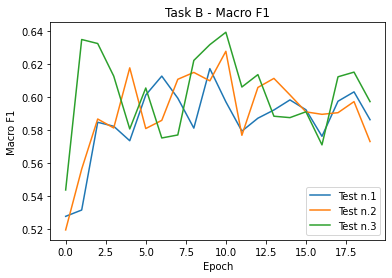

In [ ]:
# plot the F1-score on the validation set over the epochs for each trained model
for i, model_results in enumerate(models_results):
    macro_F1 = [result['valid_macro_F1'] for result in model_results]
    plt.plot(macro_F1, label='Test n.'+str(i+1))

plt.title('Task B - Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.show()

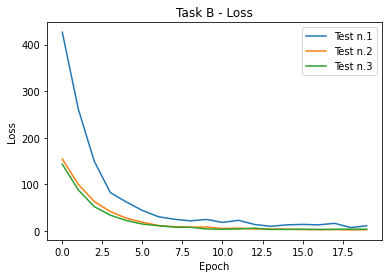

In [ ]:
# plot the loss on the training set over the epochs for each trained model
for i, model_results in enumerate(models_results):
    losses = [result['total_loss'] for result in model_results]
    plt.plot(losses, label='Test n.'+str(i+1))

plt.title('Task B - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

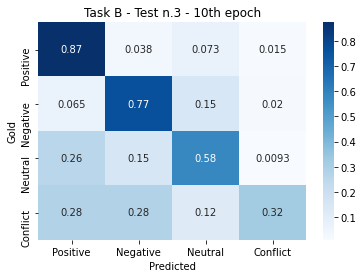

In [ ]:
# plot the confusion matrix of the best model
best = models_results[2][10]

cm = best['cm']

ax = plt.axes()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2g', ax=ax, 
            xticklabels=['Positive', 'Negative', 'Neutral', 'Conflict'], 
            yticklabels=['Positive', 'Negative', 'Neutral', 'Conflict'])

ax.set_title('Task B - Test n.3 - 10th epoch')
plt.xlabel('Predicted')
plt.ylabel('Gold')
plt.show()

In [ ]:
# printing the saved information about the best model
pprint(best)

{'cm': array([[0.87362637, 0.03846154, 0.07326007, 0.01465201],
       [0.06514658, 0.76872964, 0.1465798 , 0.01954397],
       [0.25925926, 0.14814815, 0.58333333, 0.00925926],
       [0.28      , 0.28      , 0.12      , 0.32      ]]),
 'n_epoch': 10,
 'per_class_precision': {'conflict': 0.3333333333333333,
                         'negative': 0.7972972972972973,
                         'neutral': 0.5887850467289719,
                         'positive': 0.8517857142857143},
 'total_loss': 3.6310725404764526,
 'valid_macro_F1': 0.6394744594908982,
 'valid_macro_precision_sentiments': 0.6428003479113292}


#Task A+B

In this section we are going to perform the evaluation of the best models for task A and task B by stacking the model B on top of the model A. So, we are going to use the predictions of the model A to input the model B performing the task A+B.

##Loading models

In [ ]:
# loading best model A
loaded_model_a = AModelPL.load_from_checkpoint(
    ROOT + FOLDER_A + 'Test n.2/epoch=28-valid_macro_F1=0.8032.ckpt'
).to(device)

loaded_model_a.eval()
loaded_model_a.freeze()

In [ ]:
# instantiating the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# loading best model B
loaded_model_b = BModelPL.load_from_checkpoint(
    ROOT + FOLDER_B + 'Test n.3/epoch=10-valid_macro_F1=0.6395.ckpt'
).to(device)

loaded_model_b.eval()
loaded_model_b.freeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Data

In [ ]:
# collate function
def collate_fn(samples):
        
        #ids of the instances
        ids = [sample['id'] for sample in samples]
        
        # encoded words of the texts
        inputs = [sample['inputs'] for sample in samples]

        # encoded BIOs tags
        labels_BIO = [sample['labels_BIO'] for sample in samples]

        # sentiments labels
        labels_sentiments = [sample['labels_sentiments'] for sample in samples]

        # lengths of the texts
        lengths = [len(input) for input in inputs]
        lengths = torch.tensor(lengths, device='cpu')

        # padding the texts and the BIOs tags
        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
        labels_BIO = torch.nn.utils.rnn.pad_sequence(labels_BIO, batch_first=True, padding_value=0)

        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'inputs': inputs, 
            'labels_BIO':labels_BIO, 
            'labels_sentiments': labels_sentiments,
            'lengths': lengths
        }

# vocabulary of the sentiments
labels_sentiments_vocabulary = build_labels_sentiments_vocab()

# training dataset A 
train_dataset = ADataset(path_restaurants_train, path_laptops_train, device)

# vocabulary of words
vocabulary = build_vocab(train_dataset, min_freq=1)

# vocabulary of BIOs tags
labels_BIO_vocabulary = build_labels_BIO_vocab(train_dataset)

# development dataset A
dev_dataset = ADataset(
    path_restaurants_dev, 
    path_laptops_dev, 
    device=device)

# indexing the dev dataset
dev_dataset.index_dataset(
    vocabulary=vocabulary, 
    labels_BIO_vocabulary=labels_BIO_vocabulary)

# dev dataloader
dev_dataloader = DataLoader(
    dev_dataset, 
    batch_size=32, 
    collate_fn=collate_fn)

100%|██████████| 1086/1086 [00:00<00:00, 11678.63it/s]


In [ ]:
# saving the itos list of the vocabulary of words in a file
with open(ROOT + 'vocabulary_itos.txt', 'wb') as vocab_file:
    pickle.dump(vocabulary.itos, vocab_file)

In [ ]:
# SAME FUNCTION OF THE DATASET B
# function that duplicate the instances for each aspect term in the text
def generate_sentence_aspect_pairs(sentences_BIOs, ids):
        
        data = []

        # dict: id -> { i1->([i1,i1+1,..e1],sentiment1), i2->([i2,i2+1,..e2], sentiment2), ... }
        id2start_aspect2list_index_aspect = {}

        # for each instance
        for id, sentence_BIOs in zip(ids, sentences_BIOs):
            
            id2start_aspect2list_index_aspect[id] = {}

            # building the original text
            sentence = ' '.join([w for w, _ in sentence_BIOs])

            # building the id2start_aspect2list_index_aspect dictionary 
            for i, (w, BIO) in enumerate(sentence_BIOs):
                if BIO == 2: #'B'
                    id2start_aspect2list_index_aspect[id][i] = ([i])
                    j = i + 1 
                    while j < len(sentence_BIOs) and sentence_BIOs[j][1] == 3: #'I'
                        id2start_aspect2list_index_aspect[id][i].append(j)
                        j += 1
            
            # if there is at least one aspect term in the sentence
            # we append the new instance in the data
            if len(id2start_aspect2list_index_aspect[id].keys()) > 0:
                data.append(
                    (id, sentence, id2start_aspect2list_index_aspect[id])
                    )
                

        return_data = []

        # for each new instance
        for id, sentence, start_aspect2indexes_aspect in data:
            
            sentence_splitted = sentence.split()
            j = 0
            
            # for each aspect term
            for start in start_aspect2indexes_aspect:
                indexes_aspect = start_aspect2indexes_aspect[start]
                end = indexes_aspect[-1]

                sentence1 = ''

                # adding the " to highlight the aspect term
                for i, w in enumerate(sentence_splitted):
                    
                    if i == start and i == end:
                        sentence1 += '"'
                        sentence1 += w
                        sentence1 += '" '
                                     
                    elif i == start:
                        sentence1 += '"'
                        sentence1 += (w + ' ')

                    elif i == end:
                        sentence1 += w
                        sentence1 += '" '

                    else:
                        sentence1 += (w + ' ')
                
                # retrieving the aspect term
                aspect = ' '.join(sentence_splitted[start:end+1])

                sentence1 = sentence1.strip()
                aspect = aspect.strip()
                
                # generating a new id for the instance
                id_n_aspect = str(id) + '.' + str(j)

                # adding the new instance
                return_data.append(
                    (id_n_aspect, sentence1, aspect)
                )

                j += 1

        # returning the data
        return return_data

In [ ]:
# SAME FUNCTION OF THE DATASET B
# function that duplicate the instances for each sentiment generating the auxiliary sentences
def generate_sentence_pairs_data(sentence_aspect_pairs_data):

        data = []

        # for each instance
        for id, sentence1, aspect in sentence_aspect_pairs_data:

            # for each sentiment
            for i_label, label in enumerate(labels_sentiments_vocabulary.itos):
                
                # generating the auxiliary sentence of the shape
                # aspect:sentiment
                sentence2 = aspect + ':' + label

                # generating a new id
                new_id = str(id) + '.' + str(i_label)

                # adding the new instance to the data
                data.append(
                    (new_id, sentence1, sentence2)
                )

        # returning the data
        return data

In [ ]:
# function that returns the aspect terms (and the respectively sentiments)
# from a text and its BIOs tag sequence
def get_aspects_sentiments(sentence, BIOs, sentiments):

    # split the sentence to obtain a list of words
    splitted_sentence = sentence.split()
    
    # the list to return
    r = []

    # variable to count the number of B in the BIOs sequence
    # (i.e. the number of aspect terms)
    n_B = 0

    # for each word
    for i, w in enumerate(splitted_sentence):

        # if the respectively BIO tag is a B
        # i.e. an aspect is starting
        if BIOs[i] == 2:

            # append in the list to return the couple with the starting word of
            # the aspect term and the respectively sentiment
            r.append(
                ([w], sentiments[n_B])
            )

            # increment the number of aspect terms in the text
            n_B += 1

            # as long as the following words in the text are part of that aspect term
            # (or the end of the text is reached)
            i += 1
            while i < len(BIOs) and BIOs[i] == 3:

                # append in the list of the words of the aspect term the word
                r[-1][0].append(splitted_sentence[i])
                i += 1

    # join the words components the aspect term in a single string
    r = [(' '.join(w for w in s), l) for s, l in r]

    # returning the list of the aspect terms
    return r

##Test

In [ ]:
# dict: id -> {predicted aspect term -> predicted sentiment, ...}
id2pred = {}

# dict: id -> {gold aspect term -> gold sentiment}, ...}
id2gold = {}

# for each batch in the dataloader
for batch in tqdm(dev_dataloader):

    ids = batch['ids']
    inputs = batch['inputs']
    lengths = batch['lengths']
    labels_BIO = batch['labels_BIO'].tolist()
    labels_sentiments = batch['labels_sentiments']
    
    #print('ids:', ids)
    #print('inputs:', inputs)
    #print('lengths:', lengths)
    #print('labels_BIO:', labels_BIO)
    #print('labels_sentiments:', labels_sentiments)

    # obtaining the predictions from the model A
    _, predictionsA = loaded_model_a(inputs, lengths)
    predictionsA = predictionsA.tolist()
    #print('predictionsA:', predictionsA)

    # deleting the pad from the gold sequence of BIOs tags and from the predicted ones
    labels_BIO = [labels_BIO[i][:l] for i, l in enumerate(lengths)]
    predictionsA = [predictionsA[i][:l] for i, l in enumerate(lengths)]
    #print('labels_BIO without pad:', labels_BIO)
    #print('predictionsA without pad:', predictionsA)
    
    # retrieving the original text
    raw_sentences = [' '.join(w for w, _ in dev_dataset.get_raw_element(id)[0]) for id in ids]
    #print('raw_sentences:', raw_sentences)

    # associating to each word the predicted BIO tag
    sentences_BIOs = [list(zip(sentence.split(), prediction)) for sentence, prediction in zip(raw_sentences, predictionsA)]
    #print('sentences_BIOs:', sentences_BIOs)

    # function that duplicate the instances for each sentiment generating the auxiliary sentences
    sentence_pairs = generate_sentence_pairs_data(
        # function that duplicate the instances for each aspect term in the text
        generate_sentence_aspect_pairs(
            sentences_BIOs, ids
        )
    )
    #print('sentence_pairs:', sentence_pairs)   

    # retrieving the new ids
    new_ids = [sentence_pair[0] for sentence_pair in sentence_pairs]

    # retrieving the original texts
    sentences1 = [sentence_pair[1] for sentence_pair in sentence_pairs]

    # retrieving the auxiliary sentences
    sentences2 = [sentence_pair[2] for sentence_pair in sentence_pairs]
    
    #print('new_ids:', new_ids)   
    #print('sentences1:', sentences1)   
    #print('sentences2:', sentences2)   

    if new_ids:
        
        # tokenize the sentences
        tokenized_sentences = tokenizer(sentences1, sentences2, padding=True)
        #print('tokenized_sentences:', tokenized_sentences)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        #print('tokens:', tokens)   
        #print('token_type_ids:', token_type_ids)   
        #print('attention_mask:', attention_mask)   

        tokens = torch.tensor(tokens, device=device)
        token_type_ids = torch.tensor(token_type_ids, device=device)
        attention_mask = torch.tensor(attention_mask, device=device)

        # computing the forward step for the model B
        out2 = loaded_model_b(tokens, token_type_ids, attention_mask)
        #print('out2.shape:', out2.shape)
        #print('out2:', out2)
        
        # computing the predictions 

        out2 = out2.reshape(len(out2)//4, 4)
        #print('out2.shape:', out2.shape)
        #print('out2:', out2)

        predictionsB = torch.argmax(out2, -1).tolist()
        #print('predictionsB:', predictionsB)

        # dict: id_sentence.id_aspect -> probs
        id_n_aspect2predB = {}
        for i in range(0, len(new_ids), 4):
            id, n_aspect, _ = new_ids[i].split('.')
            id_n_aspect2predB[id + '.' + n_aspect] = predictionsB[i//4]
        #print('id_n_aspect2predB:', id_n_aspect2predB)

        # dict: id_sentence -> [predicted_sentiments]
        id2predB = {}
        for id in ids:
            id2predB[id] = []
        #print('id2predB:', id2predB)

        for id_n_aspect in id_n_aspect2predB:
            id, n_aspect = id_n_aspect.split('.')
            id2predB[int(id)].append(id_n_aspect2predB[id_n_aspect])
        #print('id2predB:', id2predB)

        predictionsB = list(id2predB.values())
        
        # list of predicted sentiments
        predictionsB = [[labels_sentiments_vocabulary.itos[p] for p in pred] for pred in predictionsB]
        #print('predictionsB:', predictionsB)

    #print()
    #print('GOLD')
    #for sentence, BIOs, sentiments in zip(raw_sentences, labels_BIO, labels_sentiments):
    #    print('get_aspects_sentiments:', get_aspects_sentiments(sentence, BIOs, sentiments))
    #print()
        
    #print()
    #print('PREDICTIONS')
    #for sentence, BIOs, sentiments in zip(raw_sentences, predictionsA, predictionsB):
        #print('get_aspects_sentiments:', get_aspects_sentiments(sentence, BIOs, sentiments))
    #print()
    
    # for each instance
    for id, sentence, pred_BIOs, pred_sentiments, gold_BIOs, gold_sentiments in zip(ids, raw_sentences, predictionsA, predictionsB, labels_BIO, labels_sentiments):

        # retrieving the predicted aspect terms and the respectively predicted sentiments
        pred_list = get_aspects_sentiments(sentence, pred_BIOs, pred_sentiments)

        # retrieving the gold aspect terms and the respectively gold sentiments
        gold_list = get_aspects_sentiments(sentence, gold_BIOs, gold_sentiments)
        
        # saving the predicted aspect terms and the respectively sentiments in the pred dict
        if len(pred_list) == 0:
            id2pred[id] = []
        for pred_aspect, pred_sentiment in pred_list:
            if id in id2pred:
                id2pred[id].append([pred_aspect, pred_sentiment])
            else:
                id2pred[id] = [(pred_aspect, pred_sentiment)]
        
        # saving the gold aspect terms and the respectively sentiments in the gold dict
        # saving the predicted aspect terms and the respectively sentiments in the pred dict
        if len(gold_list) == 0:
            id2gold[id] = []
        for gold_aspect, gold_sentiment in gold_list:
            if id in id2gold:
                id2gold[id].append([gold_aspect, gold_sentiment])
            else:
                id2gold[id] = [(gold_aspect, gold_sentiment)]

print()
print(id2pred)
print(id2gold)

100%|██████████| 34/34 [00:07<00:00,  4.66it/s]


{0: [], 1: [('wines', 'negative')], 2: [('staff', 'positive')], 3: [], 4: [('appetizers', 'neutral'), ['main dishes', 'neutral']], 5: [('river', 'positive')], 6: [('reservation', 'negative')], 7: [('price sushi', 'positive')], 8: [], 9: [], 10: [], 11: [('fortune', 'negative')], 12: [], 13: [('food', 'positive')], 14: [], 15: [], 16: [('food', 'positive')], 17: [('staff', 'positive'), ['food', 'positive'], ['place', 'positive']], 18: [], 19: [('dinner', 'neutral')], 20: [('food', 'positive')], 21: [('plate', 'neutral')], 22: [], 23: [], 24: [('desserts', 'positive')], 25: [], 26: [('sushi bar chef', 'neutral'), ['ala carte', 'neutral']], 27: [], 28: [], 29: [], 30: [], 31: [('enjoyed', 'positive'), ['pizza santa', 'positive'], ['fe chopped', 'positive'], ['salad', 'positive'], ['fish', 'positive'], ['chips', 'positive']], 32: [('drinks', 'neutral')], 33: [('lava cake dessert', 'positive')], 34: [], 35: [('seafood dishes', 'neutral'), ['appetizers', 'neutral']], 36: [], 37: [('value', 

##Evaluation

In [ ]:
# function that takes in input the dictionaries with
# the golds and the predictions for each instance
def evaluate(id2golds, id2preds):

    all_sentiments = ["positive", "negative", "neutral", "conflict"]
    scores = {cat: {"TP": 0, "FP": 0, "FN": 0} for cat in all_sentiments + ["ALL"]}
    
    # for each instance
    for id in id2golds:
        
        # for each sentiment
        for cur_sentiment in all_sentiments:
            
            # we consider only the golds and the predictions within the cur_sentiment

            gold_aspects_sentiments, pred_aspects_sentiments = id2golds[id], id2preds[id]
            pred_aspects = set([pred_aspect for pred_aspect, pred_sentiment in pred_aspects_sentiments if pred_sentiment == cur_sentiment])
            gold_aspects = set([gold_aspect for gold_aspect, gold_sentiment in gold_aspects_sentiments if gold_sentiment == cur_sentiment])

            # computing TP, FP, FN within the cur_sentiment
            scores[cur_sentiment]["TP"] += len(pred_aspects & gold_aspects)
            scores[cur_sentiment]["FP"] += len(pred_aspects - gold_aspects)
            scores[cur_sentiment]["FN"] += len(gold_aspects - pred_aspects)
        
    # computing precision, recall, and F1-score for each sentiment
    for cur_sentiment in scores.keys():
        if scores[cur_sentiment]["TP"]:
            scores[cur_sentiment]["P"] = scores[cur_sentiment]["TP"] / (scores[cur_sentiment]["TP"] + scores[cur_sentiment]["FP"])
            scores[cur_sentiment]["R"] = scores[cur_sentiment]["TP"] / (scores[cur_sentiment]["TP"] + scores[cur_sentiment]["FN"])
        else:
            scores[cur_sentiment]["P"], scores[cur_sentiment]["R"] = 0, 0

        if not scores[cur_sentiment]["P"] + scores[cur_sentiment]["R"] == 0:
            scores[cur_sentiment]["F1"] = 2 * scores[cur_sentiment]["P"] * scores[cur_sentiment]["R"] / (
                    scores[cur_sentiment]["P"] + scores[cur_sentiment]["R"])
        else:
            scores[cur_sentiment]["F1"] = 0

    # compute micro precision, micro recall and micro F1-score

    TP = sum([scores[cur_sentiment]["TP"] for cur_sentiment in all_sentiments])
    FP = sum([scores[cur_sentiment]["FP"] for cur_sentiment in all_sentiments])
    FN = sum([scores[cur_sentiment]["FN"] for cur_sentiment in all_sentiments])

    if TP:
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F1 = 2 * precision * recall / (precision + recall)
    else:
        precision, recall, F1 = 0, 0, 0

    scores["ALL"]["P"] = precision
    scores["ALL"]["R"] = recall
    scores["ALL"]["F1"] = F1
    scores["ALL"]["TP"] = TP
    scores["ALL"]["FP"] = FP
    scores["ALL"]["FN"] = FN

    # compute macro precision, macro recall and macro F1-score

    scores["ALL"]["Macro_F1"] = sum([scores[cur_sentiment]["F1"] for cur_sentiment in all_sentiments])/len(all_sentiments)
    scores["ALL"]["Macro_P"] = sum([scores[cur_sentiment]["P"] for cur_sentiment in all_sentiments])/len(all_sentiments)
    scores["ALL"]["Macro_R"] = sum([scores[cur_sentiment]["R"] for cur_sentiment in all_sentiments])/len(all_sentiments)

    # returning scores
    return scores

In [ ]:
scores = evaluate(id2pred, id2gold)
pprint(scores)

{'ALL': {'F1': 0.5556594948550048,
         'FN': 458,
         'FP': 492,
         'Macro_F1': 0.46021754310775764,
         'Macro_P': 0.4453017347686862,
         'Macro_R': 0.47832643965848176,
         'P': 0.5469613259668509,
         'R': 0.564638783269962,
         'TP': 594},
 'conflict': {'F1': 0.2727272727272727,
              'FN': 13,
              'FP': 19,
              'P': 0.24,
              'R': 0.3157894736842105,
              'TP': 6},
 'negative': {'F1': 0.5605536332179931,
              'FN': 114,
              'FP': 140,
              'P': 0.5364238410596026,
              'R': 0.5869565217391305,
              'TP': 162},
 'neutral': {'F1': 0.3708920187793428,
             'FN': 131,
             'FP': 137,
             'P': 0.36574074074074076,
             'R': 0.3761904761904762,
             'TP': 79},
 'positive': {'F1': 0.636697247706422,
              'FN': 200,
              'FP': 196,
              'P': 0.6390423572744015,
              'R': 0.6343692